## Do Players Tend to Perform Better or Worse After a Big Salary Increase?
All sports teams are looking for that "Unicorn" - a player who is greatly undervalued but possesses great talent. Once a team thinks they've found their unicorn, they pay him the big bucks and lock him up. How do these supposed unicorns perform after getting their payday?

Full info here - https://github.com/benhamner/baseball/blob/master/src/import.sql

In [1]:
import pandas as pd
import numpy as np

In [2]:
batting = pd.read_csv("csv/batting.csv")
salary = pd.read_csv("csv/salary.csv")
player = pd.read_csv("csv/player.csv")

Pick range of years.

In [3]:
#work on a smaller dataset for now
start_year = 1990
end_year = 2015
ext='-01-01'
player = player[(player["debut"] > str(start_year)+ext) & (player["debut"] < str(end_year)+ext)]
batting = batting[batting["year"] > start_year]
salary = salary[salary["year"] > start_year]

Merge stints in batting. Too annoying to deal with separately.

In [4]:
batting = batting.groupby(["player_id","year"]).sum()
batting = batting.reset_index()

Make Runs Created (RC) feature, which we will use as a metric for how a given player is performing. The benefit of this statistic is that it encapsulates all the hitting stats into one number.

In [5]:
batting["single"] = batting["h"] - (batting["double"] + batting["triple"] + batting["hr"])
batting["tb"] = batting["single"] + 2*batting["double"] + 3*batting["triple"] + 4*batting["hr"]
A = batting["h"] + batting["bb"] - batting["cs"] + batting["hbp"] - batting["g_idp"] #total bases
B = batting["tb"] + 0.26*(batting["bb"] - batting["ibb"] + batting["hbp"])           #base on balls
C = 0.52*(batting["sh"] + batting["sf"] + batting["sb"])                             #sacrifices
D = batting["ab"] + batting["bb"] + batting["hbp"] + batting["sh"] + batting["sf"]   #total at bats
batting["rc"] = (A*B + C)/D

#For players that don't have the required stats for complex RC, use simple RC
batting.loc[batting["rc"].isnull()==True,"rc"]=(batting["h"]+batting["bb"])*batting["tb"]/(batting["ab"]+batting["bb"])

#set remaining isnan and isinf values to 0
batting.loc[batting["rc"].isnull()==True,"rc"] = 0
batting.loc[np.isinf(batting["rc"]),"rc"] = 0

### Analysis
Find players who have had big salary increases, i.e. a "payday", and their corresponding runs created (RC) values. A quick summary of the variables in the function get_rc_of_payday:
* plyr_id = Player ID
* player, salary, batting = dataframes containing this info
* SITR = "Salary Increase Threshold Ratio". This is the minimum fractional salary increase from the previous year to be considered a "payday".
* SMT = "Salary Minimum Threshold". This is the minimum dollar value to be considered a "payday". I'm not really concerned with players who get a salary increase from e.g. 200k to 600k. Note that if you use older years, you may have to adjust this value over time for inflation.
* GPMT = "Games Played Minimum Threshold". This is the minimum number of games a player must have played in order to use the payday/RC values from that year. 
* rc_i_avg = Number of years to average the post-payday RC value (which I call rc_i). Perhaps a player happens to have a bad/good year just after the salary increase but in general is a good/bad player post-payday. If the rc_i_avg years aren't available, pandas grabs the available ones. I don't average RC before the payday (RC_i-1), since it's usually a single good single year that leads to big contract offers in hopes that you've "picked the winning stock".  

In [6]:
def get_rc_of_payday(plyr_id,player,salary,batting,SITR,SMT,GPMT,rc_post_avg):
    plyr_slry = salary[salary["player_id"] == plyr_id]
    plyr_slry["salary_ratio"] = plyr_slry["salary"].div(plyr_slry["salary"].shift(1))
    check_payday = (plyr_slry["salary_ratio"] > SITR) & (plyr_slry["salary"] > SMT)
    payday_year = plyr_slry["year"].loc[check_payday].values
    plyr_bat = batting.loc[batting["player_id"] == plyr_id]
    data = []
    for i,y in enumerate(payday_year):
        #check that enough games were played for accurate rc in current and previous year?
        if (np.sum(plyr_bat["g"].loc[plyr_bat["year"] == y]) > GPMT) & (np.sum(plyr_bat["g"].loc[plyr_bat["year"] == y-1]) > GPMT):
            yrs = plyr_bat["year"]
            rc_post = plyr_bat.loc[(yrs>=y)&(yrs<y+rc_post_avg),"rc"].mean()
            rc_prev = plyr_bat.loc[yrs==y-1,"rc"].values[0]
            rcratio = rc_post/rc_prev
            if np.isnan(rcratio) == 0:
                data.append(plyr_id)
                data.append(player.loc[player["player_id"] == plyr_id,["name_first","name_last"]].values[0].sum())
                data.append(y)
                data.append(rc_post)
                data.append(rcratio)
                data.append(plyr_slry.loc[plyr_slry["year"]==y,"salary_ratio"].values[0])
    return data

Let's conduct this analysis and store the results in a new dataframe "data".

In [7]:
slry_inc_thresh_ratio = 2      #min increase ratio player received
slry_min_thresh = 2e6          #min final salary after the payday
gp_thresh = 100                #min number of games played
rc_post_avg = 4                   #when calc'ing rc_i, avg. over how many years? 

columns = ["player_id","player_name","year","rcpost","R","payday"]
data = pd.DataFrame(columns=columns)

for i,plyr_id in enumerate(player["player_id"]):
    d = get_rc_of_payday(plyr_id,player,salary,batting,slry_inc_thresh_ratio,slry_min_thresh,gp_thresh,rc_post_avg)
    while len(d) > 0: #gotta be a better way to do this
        data = data.append({col:d[i] for i,col in enumerate(columns)}, ignore_index=True)
        d = d[len(columns):]

/Users/silburt/anaconda2/envs/ml/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


Best rc ratio is 2.02341739896 from ['MikeMoustakas' 'moustmi01']
Worst rc ratio is 0.184124713618 from ['CaseyMcGehee' 'mcgehca01']
Biggest Salary increase is 15.6779661017x from ['MiguelCabrera' 'cabremi01']
('Fraction of players with rc_post/rc_prev < 0.85:', 0.5375)
('Fraction of players with rc_post/rc_prev > 1.15:', 0.1225)
('Fraction of players with rc_post >1 std of the mean:', 0.6525)


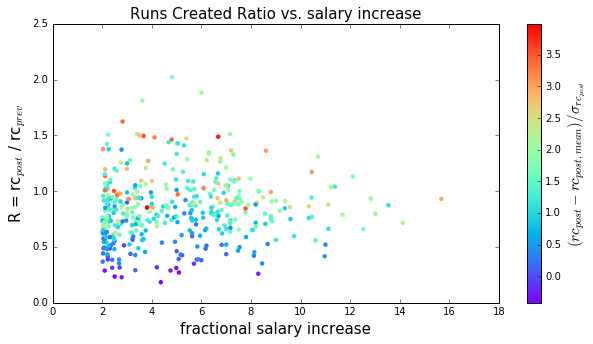

In [8]:
#plot
import matplotlib.pyplot as plt
%matplotlib inline
font=15
plt.figure(figsize=(10,5))
norm = (data["rcpost"] - batting["rc"].loc[batting["rc"] != 0.].mean())/batting["rc"].loc[batting["rc"] != 0.].std()
plt.scatter(data["payday"],data["R"], c=norm, cmap='rainbow',lw=0)
cbar = plt.colorbar()
cbar.set_label("$(rc_{post} - rc_{post,mean}) / \sigma_{rc_{post}}$",size=font)
plt.xlabel('fractional salary increase',fontsize=font)
plt.ylabel('R = rc$_{post}$ / rc$_{prev}$',fontsize=font)
plt.title('Runs Created Ratio vs. salary increase',fontsize=font)

#some stats
rcmax = data["R"].max()
rcmin = data["R"].min()
paymax = data["payday"].max()
print("Best rc ratio is "+str(rcmax)+" from "+str(data.loc[data["R"] == rcmax,["player_name","player_id"]].values[0]))
print("Worst rc ratio is "+str(rcmin)+" from "+str(data.loc[data["R"] == rcmin,["player_name","player_id"]].values[0]))
print("Biggest Salary increase is "+str(paymax)+"x from "+str(data.loc[data["payday"] == paymax,["player_name","player_id"]].values[0]))
print("Fraction of players with rc_post/rc_prev < 0.85:",data[data["R"]<0.85].shape[0]/float(data["R"].shape[0]))
print("Fraction of players with rc_post/rc_prev > 1.15:",data[data["R"]>1.15].shape[0]/float(data["R"].shape[0]))
print("Fraction of players with rc_post >1 std of the mean:",norm[norm>1].shape[0]/float(norm.shape[0]))

### Analysis Discussion
The plot above has a lot of information and warrants some explanation. The y-axis is plotting R, the ratio of the runs created after the salary increase (averaged over rc_post_avg years), rc_post, to the runs created before the salary increase, rc_prev. The x-axis is plotting the fractional salary increase, with a minimum requirement of 2x (and a minimum payday of 2 million dollars). In addition, the colours indicate the *scaled* rc_post value, i.e. rc_post minus the league mean divided by the standard deviation.

We can see that ~50% of the data points lie below R = 0.85, which I (arbitrarily) consider to be the threshold indicating a clear decrease in batting performance. However this in itself does not necessarily indicate that a player was a bad investment. We also must look at the scaled RC value after the salary increase, since perhaps a player still contributes greatly to his team even if he never performs quite as well as he did just before the payday. We see that ~65% of the players' have a scaled rc_post value greater than 1 standard deviation of the mean. This indicates that these players are still league leaders even if they didn't perform quite as well as their payday year, and are probably "worth" the salary (it's a separate discussion whether or not MLB players should be paid so much). 

In [17]:
#Top R values
data[data["R"]>1.5].sort_values(by="R",ascending=False)

,player_id,player_name,year,rcpost,R,payday
265,moustmi01,MikeMoustakas,2015.0,86.931596,2.023417,4.808743
305,ramirar01,AramisRamirez,2003.0,98.905987,1.882600,6.000000
207,karroer01,EricKarros,1995.0,92.079090,1.810261,3.615385
135,goldspa01,PaulGoldschmidt,2015.0,140.383314,1.624243,2.818182
40,burrepa01,PatBurrell,2004.0,97.139329,1.513278,3.400000
398,zimmery01,RyanZimmerman,2009.0,91.013990,1.511550,7.150538
21,beltrad01,AdrianBeltre,2002.0,86.866944,1.506526,2.240000


### Quick Investigation - Mike Moustakas
Let's briefly investigate the most correctly chosen "Unicorn", Mike Moustakas. He has the highest R value from our sample (indicating that he most significantly improved his RC output after the payday), and is also ~1.75 standard deviations from the mean, indicating a clear above average player. 

In [10]:
id='moustmi01'
batting[batting["player_id"] == id]
plyr_bat = batting.loc[batting["player_id"] == id]
plyr_bat

,player_id,year,stint,g,ab,r,h,double,triple,hr,...,bb,so,ibb,hbp,sh,sf,g_idp,single,tb,rc
18879,moustmi01,2011,1,89,338.0,26.0,89.0,18.0,1.0,5.0,...,22.0,51.0,0.0,1.0,2.0,2.0,5.0,65.0,124.0,38.112274
18880,moustmi01,2012,1,149,563.0,69.0,136.0,34.0,1.0,20.0,...,39.0,124.0,4.0,7.0,0.0,5.0,4.0,81.0,232.0,69.640261
18881,moustmi01,2013,1,136,472.0,42.0,110.0,26.0,0.0,12.0,...,32.0,83.0,1.0,5.0,1.0,4.0,13.0,72.0,172.0,45.876342
18882,moustmi01,2014,1,140,457.0,45.0,97.0,21.0,1.0,15.0,...,35.0,74.0,1.0,3.0,1.0,4.0,12.0,60.0,165.0,42.962760
18883,moustmi01,2015,1,147,549.0,73.0,156.0,34.0,1.0,22.0,...,43.0,76.0,1.0,13.0,4.0,5.0,14.0,99.0,258.0,86.931596


In [11]:
salary[salary["player_id"] == id]

,year,team_id,league_id,player_id,salary
22623,2012,KCA,AL,moustmi01,487250
23453,2013,KCA,AL,moustmi01,524500
24263,2014,KCA,AL,moustmi01,549000
25080,2015,KCA,AL,moustmi01,2640000


As can be clearly seen, Kansas City offered him a 2.64 Million dollar contract in 2015 (presumably at the end of 2014, before the 2015 season actually started), and his RC statistic in 2015 doubled. Nice work Kansas City! Hopefully his RC output continues, and this is not just an isolated good year.

## Final Discussion
Based off of the analysis above, it seems clear that "payday" players tend to perform worse after their salary increase. What could be the cause of this? Do they crack under the pressure? 

The most likely explanation is the principle of *regression to the mean*. There is always random fluctuation in the performance of a player, and out of the entire sample of MLB players there will always be some that have an extraordinarily good year. If your exceptionally good year happens to happen when your contract is ending, you get paid. 

The standard deviation of this fluctuation is player dependent, with the low R/purple coloured players in the figure above having very high standard deviation. These players are likely bad players that happened to have a fantastic year as their contract was ending. 

However, we also saw that ~65% of the players' have a scaled rc_post value greater than 1 standard deviation from the mean, indicating that these are still league leaders even if they don't perform quite as well as they did in their payday year. Thus most of the players that get big salary increases tend to deserve it. 

# Extra crap

Looks as though the magnitude of the salary increase is not correlated with performance increase, and in general it seems to be random whether or not a player will perform better/worse after a salary increase

In [12]:
columns = ["player_id","player_name","year","rcpost","R","payday"]
#plyr_id = 'craigal01'
plyr_id = 'cabremi01'
v = get_rc_of_payday(plyr_id,player,salary,batting,1.5,2e6,100,2)
v

/Users/silburt/anaconda2/envs/ml/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


['cabremi01',
 'MiguelCabrera',
 2007,
 121.17876780185759,
 0.88937830621691705,
 15.677966101694915,
 'cabremi01',
 'MiguelCabrera',
 2008,
 119.19282769880905,
 0.91726594068636735,
 1.527027027027027]